<Axes: >

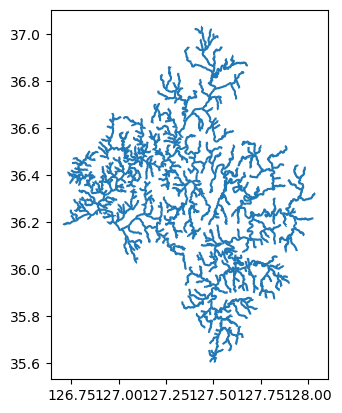

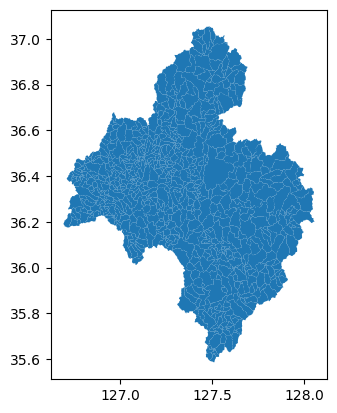

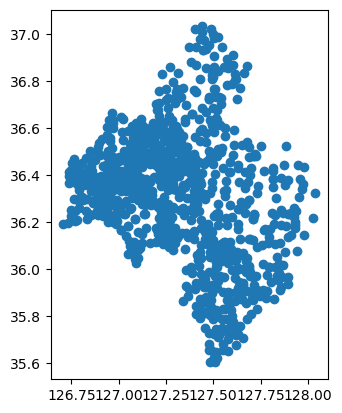

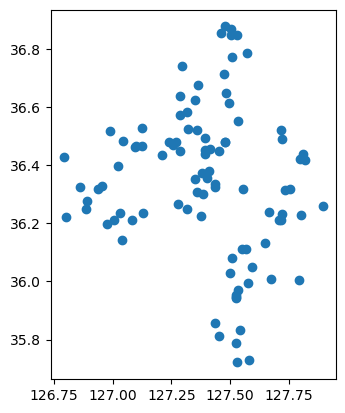

In [5]:
import geopandas as gpd

# KRF로 시작하는 shapefile 찾기
shapefiles = [r"./src/shp/KRF_ver3_CATCHMENT_금강수계.shp",
              r"./src/shp/KRF_ver3_LINE_금강수계.shp",
              r"./src/shp/KRF_ver3_NODE_금강수계.shp",
              r"./src/shp/MASKED2_MMCAT.shp",
              r"./src/shp/merged_geum_river_basin_utf8.shp"]

# shapefile 읽기
masked = gpd.read_file(shapefiles[3])

if masked.crs.to_string() != 'EPSG:4326':
    masked = masked.to_crs(epsg=4326)


catchment_gdf = gpd.clip(gpd.read_file(shapefiles[0]),   masked)
streamline_gdf = gpd.clip(gpd.read_file(shapefiles[1]), masked)
node_gdf = gpd.clip(gpd.read_file(shapefiles[2]), masked)
stations_gdf = gpd.clip(gpd.read_file(shapefiles[4], encoding="utf-8"), masked)

# 시각화

streamline_gdf.plot()
catchment_gdf.plot()
node_gdf.plot()
stations_gdf.plot()


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

# 노드와 스트림라인 데이터프레임을 가져오기 (예시로 gdfs 중 첫 번째 사용)



# 서브그래프 생성
G = nx.Graph()

# 노드 추가
for idx, row in node_gdf.iterrows():
    x, y = row['geometry'].x, row['geometry'].y
    # row.pop('geometry')
    G.add_node(row['NODE_DID'], pos=(x, y), attr=row.to_dict(), node_type="stream_node")
    

# # 엣지 추가 (INODE_ID -> ONODE_ID)
for idx, row in streamline_gdf.iterrows():
    # row.pop('geometry')
    G.add_edge(row['INODE_DID'], row['ONODE_DID'], attr=row.to_dict())



# 관측소에 가장 가까운 하천 지점 노드에 관측소 코드를 부여
for idx, station in stations_gdf.iterrows():
    station_point = station.geometry
    nearest_geom = nearest_points(station_point, node_gdf.unary_union)[1]
    nearest_node = node_gdf[node_gdf.geometry == nearest_geom]['NODE_DID'].values[0]
    G.nodes[nearest_node]["attr"]["gauge_code"] = int(station["Code"])


for idx, catchment in catchment_gdf.iterrows():
    # catchment의 폴리곤 내에 있는 node_type = "stream_node"인 노드들을 찾아서 해당 catchment의 라벨을 부여
    # !TODO
    catchment_polygon = catchment.geometry
    for node_id in G.nodes():
        node = G.nodes[node_id]
        if "node_type" in node and node["node_type"] == "stream_node":
            node_point = node["attr"]["geometry"]
            if catchment_polygon.contains(node_point):
                node["attr"]["catchment_label"] = catchment["SB_ID"]
                node["attr"]["catchment_area"] = catchment["AREA"]

G.remove_node('3014010101')

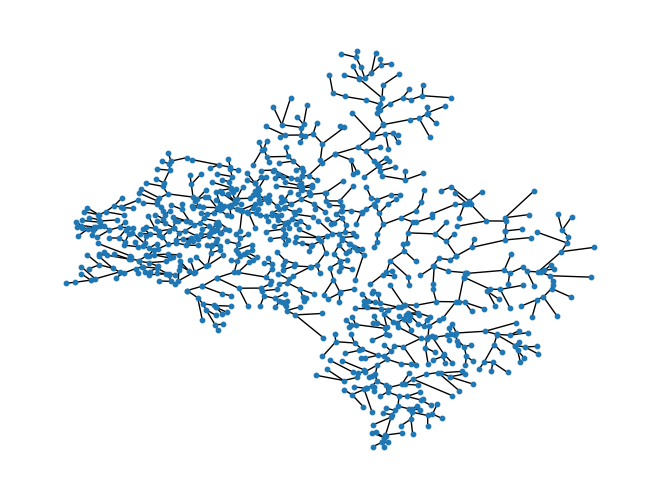

In [4]:
# 구축한 그래프를 시각화
nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=10)

In [23]:
G.nodes(data=True)

NodeDataView({'3001011500': {'pos': (127.52960840100002, 35.72019274100006), 'attr': {'OBJECTID': 2760, 'NODE_ID': '30010115', 'NODE_DID': '3001011500', 'NODE_X': 127.529608, 'NODE_Y': 35.720193, 'WGM_ID': None, 'WGM_NM': None, 'WTM_ID': None, 'WTM_NM': None, 'WAM_ID': None, 'WAM_NM': None, 'DAM_NM': None, 'BO_NM': None, 'LU_RCH_ID': '30010113', 'LU_RCH_DID': '3001011300', 'RU_RCH_ID': '30010114', 'RU_RCH_DID': '3001011400', 'LD_RCH_ID': '30010115', 'LD_RCH_DID': '3001011500', 'RD_RCH_ID': None, 'RD_RCH_DID': None, 'NODE_SN': '15', 'NODE_DIV': '00', 'RCH_NUM': 3.0, 'S_FLAG': 0.0, 'E_FLAG': 0.0, 'C_FLAG': 1.0, 'DAM_FLAG': 0.0, 'BO_FLAG': 0.0, 'WGM_FLAG': 0.0, 'WTM_FLAG': 0.0, 'WAM_FLAG': 0.0, 'SB_FLAG': 0.0, 'R_FLAG': 0.0, 'FLAG_ID': '1000000', 'geometry': <POINT (128 35.7)>, 'gauge_code': 3001605}, 'node_type': 'stream_node'}, '3001020900': {'pos': (127.5789257890001, 35.72945275600006), 'attr': {'OBJECTID': 2784, 'NODE_ID': '30010209', 'NODE_DID': '3001020900', 'NODE_X': 127.578926, '